In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import cv2
data = pd.read_csv("./labels_final.csv")
img_paths_tif = "./data_final/"+data["path"]
data_jpeg = pd.read_csv("./labels_final_jpeg.csv")
img_paths_jpeg = "./data_final/"+data["path"]
label = data["label"]

In [2]:
from sklearn.model_selection import train_test_split
train_img_paths,test_img_paths,train_label,test_label = train_test_split(img_paths_jpeg,label,test_size=0.2,random_state=0,stratify=label)

In [3]:
def tf_train_data_generator(images, labels, is_training, batch_size=32):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename,labels):
        #reading path 
        image_string = tf.io.read_file(filename)
        #decoding image
        image = tf.image.decode_jpeg(image_string, channels=3)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        
        image = tf.image.resize(image, [400, 400])
        
        y = tf.one_hot(tf.cast(labels, tf.uint8), 16)
        return image,y
    
    def preprocess(image,labels):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        image = tf.image.random_hue(image, 0.08)
        image = tf.image.random_saturation(image, 0.6, 1.6)
        image = tf.image.random_brightness(image, 0.05)
        image = tf.image.random_contrast(image, 0.7, 1.3)
        return image,labels
    

    dataset = tf.data.Dataset.from_tensor_slices((images,labels))
    
    if is_training:
        dataset = dataset.shuffle(len(images))  # depends on sample size
        
    # Transform and batch data at the same time
    dataset = dataset.map(parse_function,num_parallel_calls=tf.data.AUTOTUNE).map(preprocess,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=batch_size,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [4]:
def tf_test_data_generator(images, labels, is_training, batch_size=32):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename,labels):
        #reading path 
        image_string = tf.io.read_file(filename)
        #decoding image
        image = tf.image.decode_jpeg(image_string, channels=3)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        
        image = tf.image.resize(image, [400, 400])
        
        y = tf.one_hot(tf.cast(labels, tf.uint8), 16)
        return image,y

    dataset = tf.data.Dataset.from_tensor_slices((images,labels))
    
    if is_training:
        dataset = dataset.shuffle(len(images))  # depends on sample size
        
    # Transform and batch data at the same time
    dataset = dataset.map(parse_function,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=batch_size,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [5]:
batch_size = 40
train_ds = tf_train_data_generator(train_img_paths, train_label, is_training=True, batch_size=batch_size)
test_ds = tf_test_data_generator(test_img_paths,test_label,is_training=True, batch_size=batch_size)

In [6]:
l = dict(label.value_counts())
l = sorted(l.items())
for c,num in l:
    print("For class ",c," no. of images ",num)

For class  0  no. of images  3016
For class  1  no. of images  2994
For class  2  no. of images  2993
For class  3  no. of images  3005
For class  4  no. of images  2994
For class  5  no. of images  2999
For class  6  no. of images  2985
For class  7  no. of images  3000
For class  8  no. of images  3003
For class  9  no. of images  3002
For class  10  no. of images  3002
For class  11  no. of images  2992
For class  12  no. of images  3006
For class  13  no. of images  3007
For class  14  no. of images  3006
For class  15  no. of images  2996


In [7]:
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(400,400,3))
vgg.trainable = False

In [8]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0     

In [9]:
model = tf.keras.Sequential([
    vgg,
    keras.layers.Conv2D(32,3,activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation="relu"),
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dense(16,activation="softmax")
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 12, 12, 512)       14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 32)        147488    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               102528    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1

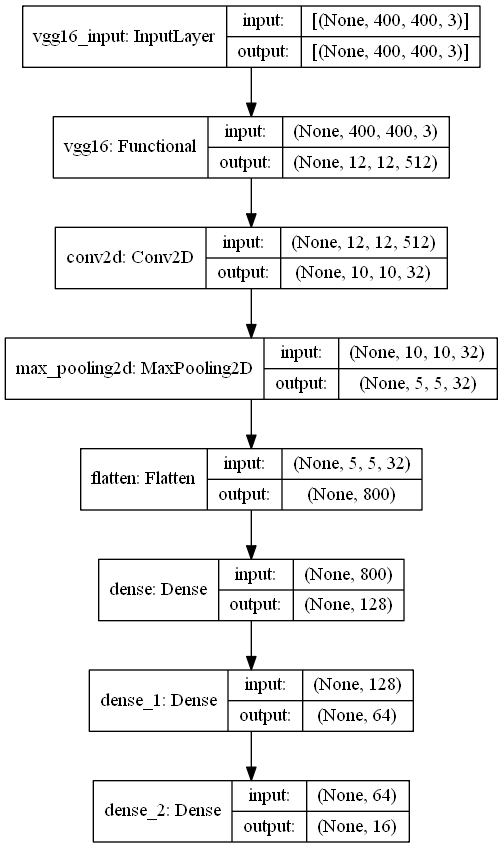

In [11]:
tf.keras.utils.plot_model(model,"model_1.png",show_shapes=True)

In [12]:
#callbacks
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint
#model check point
filepath = "./best_model/best_model_1.h5"
Checkpoint = ModelCheckpoint(filepath=filepath,monitor='val_acc',save_best_only=True,mode='max')

log_dir = "./tensorboard_logs/model_1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

class stopTraining(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs ={}):
    self.val_acc = -1
  
  def on_epoch_end(self,epoch,logs={}):
    self.val_acc = logs['val_acc']
    if self.val_acc >0.60:
        self.model.stop_training = True

stopTraining = stopTraining()

model.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.CategoricalCrossentropy(),metrics=["acc",tfa.metrics.F1Score(num_classes = 20,average = "micro",threshold =0.5)])

D:\conda\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [13]:
tf.keras.backend.clear_session()
tf.keras.backend.clear_session()
history = model.fit(train_ds,
                    validation_data = test_ds,
                    epochs=20,callbacks = [Checkpoint,tensorboard_callback,stopTraining])

Epoch 1/20
960/960 [==============================] - ETA: 0s - loss: 1.6258 - acc: 0.4857 - f1_score: 0.4265

D:\conda\envs\tf_gpu\lib\site-packages\keras\metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


960/960 [==============================] - 809s 815ms/step - loss: 1.6258 - acc: 0.4857 - f1_score: 0.4265 - val_loss: 1.3549 - val_acc: 0.5682 - val_f1_score: 0.5335
Epoch 2/20
960/960 [==============================] - 801s 834ms/step - loss: 1.2933 - acc: 0.5954 - f1_score: 0.5672 - val_loss: 1.2071 - val_acc: 0.6208 - val_f1_score: 0.5923


Stopped training because, validation accuracy has reached 60.08% in just one epoch.

In [17]:
from prettytable import PrettyTable

pt = PrettyTable(["Model","Model Description","Train Accuracy","Train_loss","Test Accuracy","Test_loss"])
pt.add_row(["VGG16","No layers of vgg16 are Trainable.\n Dense Layers are used.","59.54%","1.2933","62.08%","1.2071"])
print(pt)

+-------+-----------------------------------+----------------+------------+---------------+-----------+
| Model |         Model Description         | Train Accuracy | Train_loss | Test Accuracy | Test_loss |
+-------+-----------------------------------+----------------+------------+---------------+-----------+
| VGG16 | No layers of vgg16 are Trainable. |     59.54%     |   1.2933   |     62.08%    |   1.2071  |
|       |       Dense Layers are used.      |                |            |               |           |
+-------+-----------------------------------+----------------+------------+---------------+-----------+
